In [1]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import bisect

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
indexData = pd.read_csv('../data/indexData_uk.txt', sep='\t', header=None)

In [3]:
header = ['Term', 'Li_Len', '1s_Qnt', '1rl_Avg', 'Liwo1_Len', 'C_Li_Len', 'C_Liwo1_Len', 'EWAH_bitmap_Bytes', 'Bitmap_1s']
indexData.columns = header

In [4]:
indexData['Bitmap_Bytes'] = indexData.Li_Len / 8 + 1
indexData['Li_Bytes'] = indexData.Li_Len * 4
indexData['Liwo1_Bytes'] = indexData.Liwo1_Len * 4
indexData['C_Li_Bytes'] = indexData.C_Li_Len * 4
indexData['C_Liwo1_Bytes'] = indexData.C_Liwo1_Len * 4

# SS_Ratio (Space Saving): 1 - (CompressedSize / UncompressedSize) #
indexData['SS_Ratio_Li'] = 1 - (indexData.C_Li_Bytes / indexData.Li_Bytes)
indexData['SS_Ratio_Liwo1'] = 1 - (indexData.C_Liwo1_Bytes / indexData.Liwo1_Bytes)

indexData['SS_Ratio_Hybrid_Un'] = 1 - (indexData.Liwo1_Bytes + indexData.Bitmap_Bytes) / indexData.Li_Bytes
indexData['SS_Ratio_Hybrid_Co'] = 1 - (indexData.C_Liwo1_Bytes + indexData.EWAH_bitmap_Bytes) / indexData.Li_Bytes

In [5]:
indexData[indexData.columns[1:]]
#indexData[['SS_Ratio_Li', 'SS_Ratio_Liwo1', 'SS_Ratio_Hybrid_Un', 'SS_Ratio_Hybrid_Co']]

,Li_Len,1s_Qnt,1rl_Avg,Liwo1_Len,C_Li_Len,C_Liwo1_Len,EWAH_bitmap_Bytes,Bitmap_1s,Bitmap_Bytes,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co
0,528517,216943,2.036,311574,53021,35449,64376,216943,66065.625,2114068,1246296,212084,141796,0.900,0.886,0.379,0.902
1,171519,31866,1.698,139653,25845,22452,20724,31866,21440.875,686076,558612,103380,89808,0.849,0.839,0.155,0.839
2,138044,20468,1.628,117576,22408,20154,16684,20468,17256.500,552176,470304,89632,80616,0.838,0.829,0.117,0.824
3,818,2,1.000,816,366,365,16,2,103.250,3272,3264,1464,1460,0.553,0.553,-0.029,0.549
4,184,5,1.000,179,91,90,16,5,24.000,736,716,364,360,0.505,0.497,-0.005,0.489
5,865,223,5.868,642,305,282,60,223,109.125,3460,2568,1220,1128,0.647,0.561,0.226,0.657
6,416,5,1.250,411,206,204,20,5,53.000,1664,1644,824,816,0.505,0.504,-0.020,0.498
7,265,1,1.000,264,137,141,8,1,34.125,1060,1056,548,564,0.483,0.466,-0.028,0.460
8,407,2,1.000,405,188,184,8,2,51.875,1628,1620,752,736,0.538,0.546,-0.027,0.543
9,4,1,1.000,3,3,3,8,1,1.500,16,12,12,12,0.250,0.000,0.156,-0.250


In [6]:
# Size of vocabulary: 3238468 (terms) #
# 121153 / 3238468 = 0,03741059 #
indexData[indexData.columns[9:]].describe()

,Bitmap_Bytes,Li_Bytes,Liwo1_Bytes,C_Li_Bytes,C_Liwo1_Bytes,SS_Ratio_Li,SS_Ratio_Liwo1,SS_Ratio_Hybrid_Un,SS_Ratio_Hybrid_Co
count,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000,121153.000
mean,352.170,11237.440,9421.613,2342.826,2168.875,0.586,0.560,0.035,0.552
std,2619.199,83814.369,51883.224,10064.419,8120.778,0.140,0.210,0.110,0.216
min,1.250,8.000,4.000,8.000,8.000,0.000,-1.000,-0.031,-1.000
25%,9.125,260.000,240.000,108.000,96.000,0.501,0.496,-0.021,0.483
50%,29.500,912.000,852.000,360.000,352.000,0.589,0.579,-0.004,0.575
75%,96.375,3052.000,2916.000,1132.000,1108.000,0.687,0.678,0.044,0.680
max,156486.125,5007524.000,1354852.000,295416.000,149568.000,0.943,0.923,0.966,0.985


In [7]:
bins = np.array((.1, .2, .3, .4, .5, .6, .7, .8, .9, 1.), dtype=np.float64)
count_won_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)
count_lost_SS_Ratio_Hybrid_Co = np.zeros(10, dtype=np.float64)

#won_SS_SS_Ratio_Hybrid_Co = indexData[indexData['SS_Ratio_Hybrid_Co'] > indexData['SS_Ratio_Hybrid_Co']]['SS_Ratio_Hybrid_Co']
won_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co > SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])
lost_SS_Ratio_Hybrid_Co = np.array(indexData.query('SS_Ratio_Hybrid_Co <= SS_Ratio_Li')['SS_Ratio_Hybrid_Co'])

# Interval Type [) #
for SS_Ratio_Hybrid_Co in won_SS_Ratio_Hybrid_Co:
    count_won_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
for SS_Ratio_Hybrid_Co in lost_SS_Ratio_Hybrid_Co:
    # First interval includes NEGATIVE values #
    count_lost_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1
    
# Slower! #
#for index, row in indexData.iterrows():
#    if (row.SS_Ratio_Hybrid_Co > row.SS_Ratio_Li):
#        count_won_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1
#    else: # row.SS_Ratio_Hybrid_Co <= row.SS_Ratio_Li] #
#        count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, row.SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Co = (count_won_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100
count_lost_SS_Ratio_Hybrid_Co = (count_lost_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon\t\tLost'
previousBin = 0.0
totalWon = 0.0
totalLost = 0.0
for won, lost, bi in zip(count_won_SS_Ratio_Hybrid_Co, count_lost_SS_Ratio_Hybrid_Co, bins):
    print '[%.1f, %.1f)\t%.2f\t\t%.2f' %(previousBin, bi, won, lost)
    previousBin = bi
    totalWon += won
    totalLost += lost
print 'Total\t\t%.2f\t\t%.2f' %(totalWon, totalLost)


Bin		Won		Lost
[0.0, 0.1)	0.00		3.16
[0.1, 0.2)	0.00		1.49
[0.2, 0.3)	0.00		1.74
[0.3, 0.4)	0.00		4.05
[0.4, 0.5)	0.56		17.67
[0.5, 0.6)	3.07		23.84
[0.6, 0.7)	4.23		19.58
[0.7, 0.8)	4.41		12.70
[0.8, 0.9)	1.09		2.14
[0.9, 1.0)	0.29		0.00
Total		13.65		86.35


In [8]:
count_won_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)
#count_lost_SS_Ratio_Hybrid_Un = np.zeros(10, dtype=np.float64)

won_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un > 0')['SS_Ratio_Hybrid_Un'])
#lost_SS_SS_Ratio_Hybrid_Un = np.array(indexData.query('SS_Ratio_Hybrid_Un <= 0')['SS_Ratio_Hybrid_Un'])

# Interval Type [) #
for SS_Ratio_Hybrid_Un in won_SS_Ratio_Hybrid_Un:
    count_won_SS_Ratio_Hybrid_Un[bisect.bisect_right(bins, SS_Ratio_Hybrid_Un)] += 1
#for SS_Ratio_Hybrid_Co in lost_SS_SS_Ratio_Hybrid_Un:
#    count_lost_SS_SS_Ratio_Hybrid_Co[bisect.bisect_right(bins, SS_Ratio_Hybrid_Co)] += 1

count_won_SS_Ratio_Hybrid_Un = (count_won_SS_Ratio_Hybrid_Un / indexData.shape[0]) * 100
#count_lost_SS_SS_Ratio_Hybrid_Co = (count_lost_SS_SS_Ratio_Hybrid_Co / indexData.shape[0]) * 100

print 'Bin\t\tWon'
previousBin = 0.0
totalWon = 0.0
for won, bi in zip(count_won_SS_Ratio_Hybrid_Un, bins):
    print '[%.1f, %.1f)\t%.2f' %(previousBin, bi, won)
    previousBin = bi
    totalWon += won
print 'Total\t\t%.2f' %(totalWon)



Bin		Won
[0.0, 0.1)	32.23
[0.1, 0.2)	7.96
[0.2, 0.3)	2.60
[0.3, 0.4)	1.40
[0.4, 0.5)	0.76
[0.5, 0.6)	0.37
[0.6, 0.7)	0.42
[0.7, 0.8)	0.21
[0.8, 0.9)	0.11
[0.9, 1.0)	0.17
Total		46.25


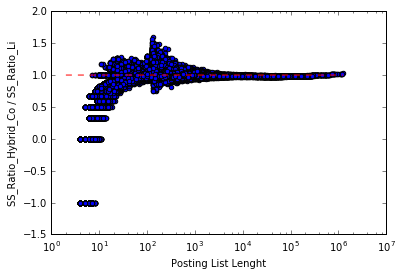

In [9]:
# SS_Ratio_Hybrid_Co / SS_Ratio_Li #

SS_Ratio_Hybrid_Co_over_SS_Ratio_Li = indexData.SS_Ratio_Hybrid_Co / indexData.SS_Ratio_Li

start = indexData.Li_Len.min()
stop = indexData.Li_Len.max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData.Li_Len, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)

ax.set_xlabel('Posting List Lenght')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')
#ax.set_yscale('log')

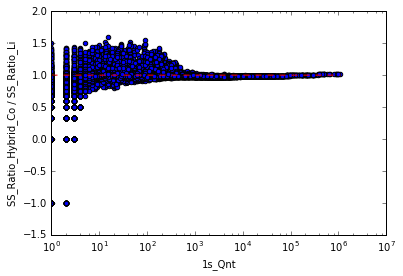

In [10]:
start = indexData['1s_Qnt'].min()
stop = indexData['1s_Qnt'].max()

s = np.arange(start, stop, 10, dtype=np.int64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)

figure, ax = plt.subplots()
ax.plot(s, threshold, color='r', linestyle='--')
ax.scatter(indexData['1s_Qnt'], SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.set_xlabel('1s_Qnt')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xscale('log')

(0.0, 1.1)

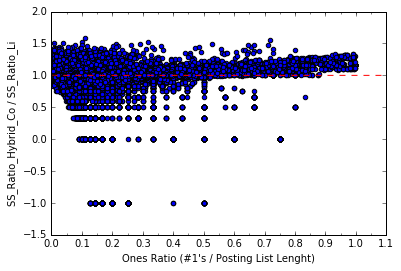

In [11]:
# How many ones do I need to win? #
# X-axis : One's proportion respect to Posting List Length #
# Y-axis : Hybrid Compression Ratio: HybridCompression / PForCompression #

start = 0.0
stop = 1.1

size = indexData.shape[0]

s = np.linspace(start, stop, size, dtype=np.float64)
threshold = np.full((len(s)), 1.0, dtype=np.float64)
onesRatio = indexData['1s_Qnt'] / indexData['Li_Len']

figure, ax = plt.subplots()
ax.scatter(onesRatio, SS_Ratio_Hybrid_Co_over_SS_Ratio_Li)
ax.plot(s, threshold, color='r', linestyle='--')
# Tickers #
min_x = MultipleLocator(0.05)
max_x = MultipleLocator(0.1)
ax.xaxis.set_major_locator(max_x)
ax.xaxis.set_minor_locator(min_x)
ax.set_xlabel('Ones Ratio (#1\'s / Posting List Lenght)')
ax.set_ylabel('SS_Ratio_Hybrid_Co / SS_Ratio_Li')
ax.set_xlim([0.0, 1.1])